
# Car Body Type Classification - Classical Machine Learning
# Project number : 82


| Name                    | Student ID |
|-------------------------|------------|
| Kenzy Tamer Ahmed       | 22P0179    |
| Yasmeen Tamer Abdelazim | 22P0057    |

## 1️ Import Libraries

In [1]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from skimage.feature import local_binary_pattern
from sklearn.neural_network import MLPClassifier
from skimage.feature import graycomatrix, graycoprops
import pandas as pd

## 2 Feature Extraction Function

In [2]:
def extract_features(img_path):
    """
    Extract handcrafted features from an image for car body classification.
    Focuses on features most relevant for distinguishing 7 car body types.
    """
    try:
        # Load and preprocess image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not read image {img_path}")
            return np.zeros(2300)  # Return zeros if image can't be read

        img = cv2.resize(img, (160, 160))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        feature_list = []

        # ==================== 1. SHAPE FEATURES (MOST IMPORTANT) ====================

        # HOG - Primary shape descriptor
        try:
            hog_features = hog(
                gray,
                orientations=9,
                pixels_per_cell=(20, 20),
                cells_per_block=(2, 2),
                block_norm='L2-Hys',
                feature_vector=True
            )
            feature_list.append(hog_features)
        except:
            # If HOG fails, use zeros
            hog_features = np.zeros(1764)  # This is the size of HOG features for 160x160 image
            feature_list.append(hog_features)

        # ==================== 2. CAR-SPECIFIC GEOMETRIC FEATURES ====================

        shape_features = []

        try:
            # Get car contour
            _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours and len(contours) > 0:
                # Find largest contour
                largest_contour = max(contours, key=cv2.contourArea)
                x, y, w, h = cv2.boundingRect(largest_contour)
                area = cv2.contourArea(largest_contour)
                perimeter = cv2.arcLength(largest_contour, True)

                # 1. ASPECT RATIO
                aspect_ratio = w / h if h > 0 and w > 0 else 1.0
                shape_features.append(aspect_ratio)

                # 2. COMPACTNESS
                compactness = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
                shape_features.append(compactness)

                # 3. SOLIDITY
                hull = cv2.convexHull(largest_contour)
                hull_area = cv2.contourArea(hull)
                solidity = area / hull_area if hull_area > 0 else 1.0
                shape_features.append(solidity)

                # 4. EXTENT
                extent = area / (w * h) if w * h > 0 else 0
                shape_features.append(extent)

                # 5. RECTANGULARITY
                rectangularity = area / (w * h) if w * h > 0 else 0
                shape_features.append(rectangularity)

                # 6. CENTROID POSITION
                M = cv2.moments(largest_contour)
                if M['m00'] != 0:
                    cx = M['m10'] / M['m00'] / w if w > 0 else 0.5
                    cy = M['m01'] / M['m00'] / h if h > 0 else 0.5
                    shape_features.extend([cx, cy])
                else:
                    shape_features.extend([0.5, 0.5])
            else:
                # Default values if no contour found
                shape_features.extend([1.0, 0, 1.0, 0, 0, 0.5, 0.5])
        except:
            # If shape extraction fails
            shape_features.extend([1.0, 0, 1.0, 0, 0, 0.5, 0.5])

        shape_features = np.array(shape_features)

        # Replace any NaN or inf with zeros
        shape_features = np.nan_to_num(shape_features, nan=0.0, posinf=0.0, neginf=0.0)
        feature_list.append(shape_features)

        # ==================== 3. TEXTURE FEATURES ====================

        # LBP
        try:
            lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
            lbp_hist = lbp_hist.astype("float") / (lbp_hist.sum() + 1e-6)
            feature_list.append(lbp_hist)
        except:
            feature_list.append(np.zeros(10))

        # Edge Density
        try:
            edges = cv2.Canny(gray, 50, 150)
            edge_density = np.sum(edges > 0) / edges.size if edges.size > 0 else 0
            feature_list.append(np.array([edge_density]))
        except:
            feature_list.append(np.array([0]))

        # ==================== 4. COLOR FEATURES ====================
#
        # HSV Histogram
        # try:
        #     hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        #     hist = cv2.calcHist([hsv], [0, 1, 2], None, [4, 4, 4],
        #                         [0, 180, 0, 256, 0, 256])
        #     hist = cv2.normalize(hist, hist).flatten()
        #     hist = np.nan_to_num(hist, nan=0.0)
        #     feature_list.append(hist)
        # except:
        #     feature_list.append(np.zeros(512))
        #
        # # Color Moments - FIXED SKEWNESS CALCULATION
        # try:
        #     color_moments = []
        #     channels = cv2.split(img)
        #     for channel in channels:
        #         channel_data = channel.astype(np.float32)
        #         mean_val = np.mean(channel_data)
        #         std_val = np.std(channel_data)
        #
        #         # FIXED: Proper skewness calculation
        #         if std_val > 0:
        #             skewness_val = np.mean(((channel_data - mean_val) / std_val) ** 3)
        #         else:
        #             skewness_val = 0
        #
        #         color_moments.extend([mean_val, std_val, skewness_val])
        #
        #     color_moments = np.array(color_moments)
        #     color_moments = np.nan_to_num(color_moments, nan=0.0)
        #     feature_list.append(color_moments)
        # except:
        #     feature_list.append(np.zeros(9))

        # ==================== 5. REGIONAL FEATURES ====================

        try:
            regional_features = []
            height, width = gray.shape

            # Top vs bottom analysis
            top_half = gray[0:height//2, :]
            bottom_half = gray[height//2:, :]

            # Roof characteristics
            roof_mean = np.mean(top_half) if top_half.size > 0 else 0
            roof_std = np.std(top_half) if top_half.size > 0 else 0
            regional_features.extend([roof_mean, roof_std])

            # Body characteristics
            body_mean = np.mean(bottom_half) if bottom_half.size > 0 else 0
            body_std = np.std(bottom_half) if bottom_half.size > 0 else 0
            regional_features.extend([body_mean, body_std])

            # Roof-to-body contrast
            roof_body_contrast = abs(roof_mean - body_mean)
            regional_features.append(roof_body_contrast)

            # Horizontal symmetry
            left_half = gray[:, :width//2]
            right_half = gray[:, width//2:]
            if left_half.shape == right_half.shape:
                symmetry = 1 - (np.abs(left_half - np.fliplr(right_half)).mean() / 255)
            else:
                symmetry = 0.5
            regional_features.append(symmetry)

            regional_features = np.array(regional_features)
            regional_features = np.nan_to_num(regional_features, nan=0.0)
            feature_list.append(regional_features)
        except:
            feature_list.append(np.zeros(6))

        # ==================== COMBINE ALL FEATURES ====================

        # Concatenate all feature arrays
        all_features = np.hstack(feature_list)

        # Final check for NaN or inf
        all_features = np.nan_to_num(all_features, nan=0.0, posinf=0.0, neginf=0.0)

        return all_features

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        # Return zeros with expected shape
        return np.zeros(2300)  # Approximate total features

## 3 Load Dataset from Folders

In [3]:
def load_dataset(folder_path):
    """
    Loads images and extracts features from a folder structure:
    folder_path/
        Class1/
            img1.jpg, img2.jpg...
        Class2/
            ...

    Args:
        folder_path (str): path to train/val/test folder

    Returns:
        X (np.array): feature vectors
        y (list): class labels (folder names)
    """
    X, y = [], []
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            features = extract_features(img_path)
            X.append(features)
            y.append(class_name)

    return np.array(X), np.array(y)
# Paths to your dataset folders
train_dir = "dataset/train"
val_dir = "dataset/valid"
test_dir = "dataset/test"

# Load datasets
X_train, y_train = load_dataset(train_dir)
X_val, y_val = load_dataset(val_dir)
X_test, y_test = load_dataset(test_dir)

print("Dataset shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)
print(np.unique(y_train))



Dataset shapes:
X_train: (5350, 1788) y_train: (5350,)
X_val: (1397, 1788) y_val: (1397,)
X_test: (802, 1788) y_test: (802,)
['Convertible' 'Coupe' 'Hatchback' 'Pick-Up' 'SUV' 'Sedan' 'VAN']


## 4 Encode Labels

In [4]:
# Convert class names to integers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

## Class Distribution

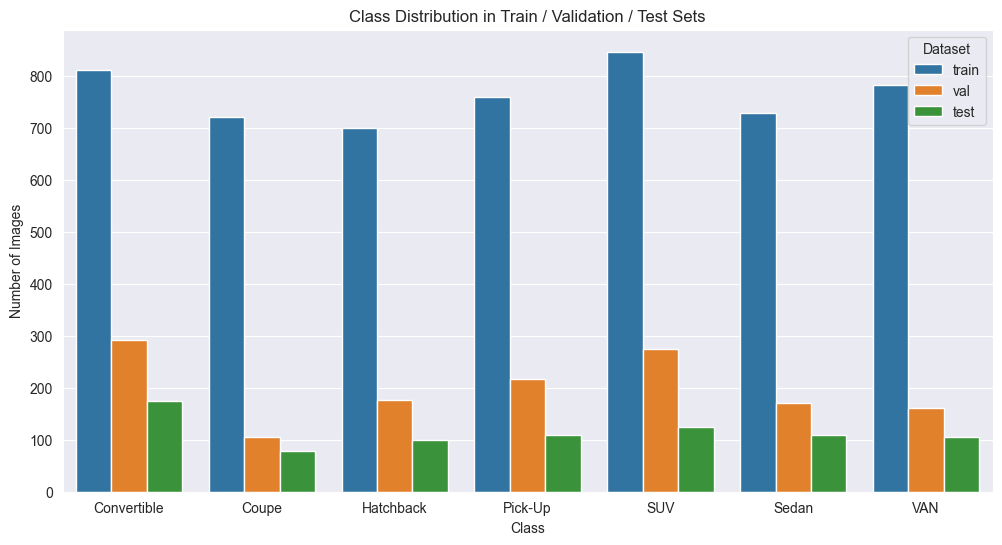

In [5]:
def plot_class_distribution(y_train, y_val, y_test, class_names):
    # Convert to DataFrame
    df = pd.DataFrame({
        'label': np.concatenate([y_train, y_val, y_test]),
        'dataset': ['train']*len(y_train) + ['val']*len(y_val) + ['test']*len(y_test)
    })

    plt.figure(figsize=(12,6))
    sns.countplot(data=df, x='label', hue='dataset', order=class_names)
    plt.title("Class Distribution in Train / Validation / Test Sets")
    plt.ylabel("Number of Images")
    plt.xlabel("Class")
    plt.legend(title="Dataset")
    plt.show()

# Call the function
plot_class_distribution(y_train, y_val, y_test, le.classes_)


## 5 Shuflling Dataset

In [6]:
X_train, y_train_enc = shuffle(X_train, y_train_enc, random_state=42)
X_val, y_val_enc = shuffle(X_val, y_val_enc, random_state=42)
X_test, y_test_enc = shuffle(X_test, y_test_enc, random_state=42)

## 6 Feature Selection

In [7]:
# # Remove near-constant features
var_thresh = VarianceThreshold(threshold=0.001)
X_train_sel = var_thresh.fit_transform(X_train)
X_val_sel   = var_thresh.transform(X_val)
X_test_sel  = var_thresh.transform(X_test)

print("After selection:", X_train_sel.shape)


After selection: (5350, 1780)


## 7 Feature Scaling

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

## 8 Dimensionality Reduction with PCA

In [9]:
pca = PCA(n_components=0.95, random_state=42)  # keep 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Feature dimensions after PCA:", X_train_pca.shape)

Feature dimensions after PCA: (5350, 442)


## 9 Train Classical ML Models

### SVM Model

SVM Validation Accuracy: 0.8088761632068718
SVM Test Accuracy: 0.8017456359102244
              precision    recall  f1-score   support

 Convertible       0.85      0.86      0.85       174
       Coupe       0.59      0.63      0.61        79
   Hatchback       0.70      0.70      0.70        99
     Pick-Up       0.84      0.88      0.86       110
         SUV       0.84      0.76      0.80       125
       Sedan       0.75      0.78      0.76       109
         VAN       0.98      0.92      0.95       106

    accuracy                           0.80       802
   macro avg       0.79      0.79      0.79       802
weighted avg       0.81      0.80      0.80       802



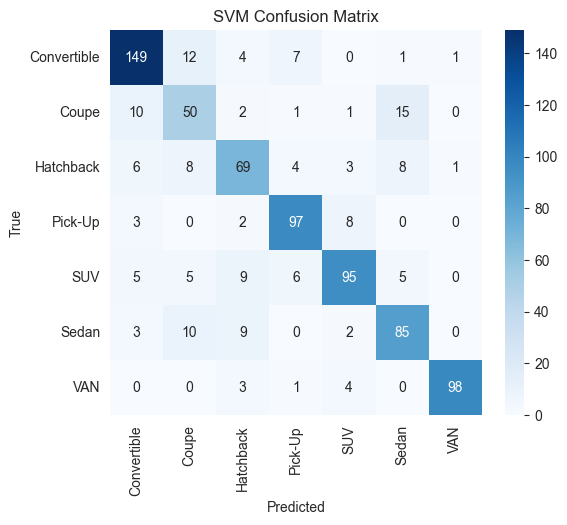

In [10]:
svm_model = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced')

# Train
svm_model.fit(X_train_pca, y_train_enc)

# Validation
y_val_pred = svm_model.predict(X_val_pca)
svm_val_acc = accuracy_score(y_val_enc, y_val_pred)
print("SVM Validation Accuracy:", svm_val_acc)

# Testing
y_test_pred = svm_model.predict(X_test_pca)
svm_test_acc = accuracy_score(y_test_enc, y_test_pred)
print("SVM Test Accuracy:", svm_test_acc)

print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

# ---- Confusion Matrix ----
cm = confusion_matrix(y_test_enc, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM Confusion Matrix")
plt.show()


### Random Forest Model

RF Validation Accuracy: 0.5261274158911954
RF Test Accuracy: 0.5374064837905237
              precision    recall  f1-score   support

 Convertible       0.57      0.59      0.58       174
       Coupe       0.25      0.24      0.25        79
   Hatchback       0.41      0.30      0.35        99
     Pick-Up       0.58      0.69      0.63       110
         SUV       0.49      0.54      0.51       125
       Sedan       0.50      0.51      0.51       109
         VAN       0.86      0.76      0.81       106

    accuracy                           0.54       802
   macro avg       0.52      0.52      0.52       802
weighted avg       0.54      0.54      0.53       802



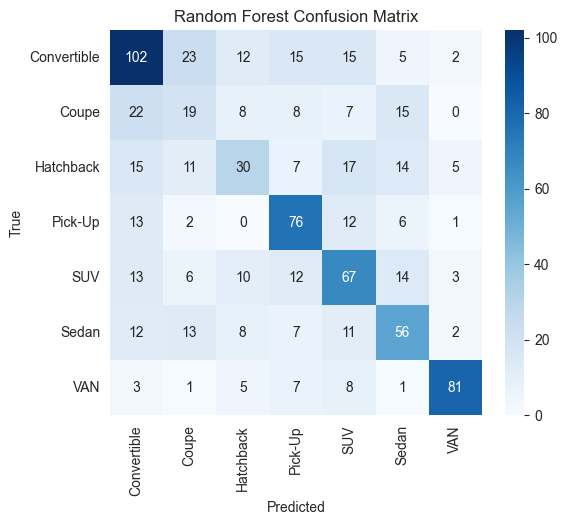

In [11]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# Train
rf_model.fit(X_train_pca, y_train_enc)

# Validation
y_val_pred = rf_model.predict(X_val_pca)
rf_val_acc = accuracy_score(y_val_enc, y_val_pred)
print("RF Validation Accuracy:", rf_val_acc)

# Testing
y_test_pred = rf_model.predict(X_test_pca)
rf_test_acc = accuracy_score(y_test_enc, y_test_pred)
print("RF Test Accuracy:", rf_test_acc)

print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_enc, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix")
plt.show()

### KNN Model

KNN Validation Accuracy: 0.6299212598425197
KNN Test Accuracy: 0.6172069825436409
              precision    recall  f1-score   support

 Convertible       0.77      0.50      0.61       174
       Coupe       0.36      0.49      0.41        79
   Hatchback       0.46      0.41      0.44        99
     Pick-Up       0.64      0.89      0.74       110
         SUV       0.72      0.58      0.64       125
       Sedan       0.47      0.62      0.54       109
         VAN       0.97      0.85      0.90       106

    accuracy                           0.62       802
   macro avg       0.63      0.62      0.61       802
weighted avg       0.65      0.62      0.62       802



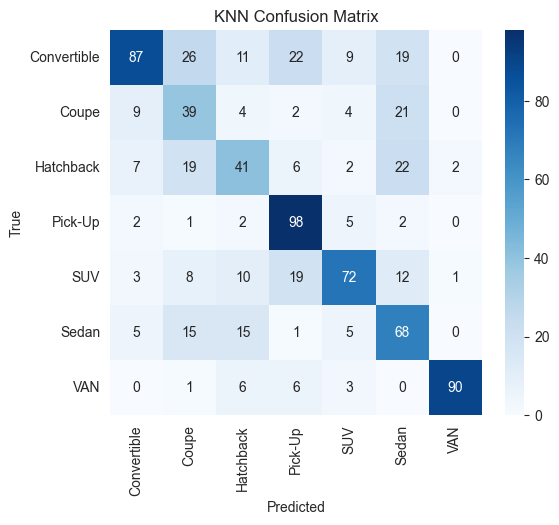

In [12]:
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train
knn_model.fit(X_train_pca, y_train_enc)

# Validation
y_val_pred = knn_model.predict(X_val_pca)
knn_val_acc = accuracy_score(y_val_enc, y_val_pred)
print("KNN Validation Accuracy:", knn_val_acc)

# Testing
y_test_pred = knn_model.predict(X_test_pca)
knn_test_acc = accuracy_score(y_test_enc, y_test_pred)
print("KNN Test Accuracy:", knn_test_acc)

print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))


# ---- Confusion Matrix ----
cm = confusion_matrix(y_test_enc, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("KNN Confusion Matrix")
plt.show()



### XGBoost Model

XGBoost Validation Accuracy: 0.6478167501789549
XGBoost Test Accuracy: 0.6658354114713217
              precision    recall  f1-score   support

 Convertible       0.75      0.70      0.72       174
       Coupe       0.43      0.44      0.43        79
   Hatchback       0.57      0.55      0.56        99
     Pick-Up       0.68      0.83      0.75       110
         SUV       0.62      0.60      0.61       125
       Sedan       0.61      0.62      0.62       109
         VAN       0.92      0.85      0.88       106

    accuracy                           0.67       802
   macro avg       0.65      0.65      0.65       802
weighted avg       0.67      0.67      0.67       802



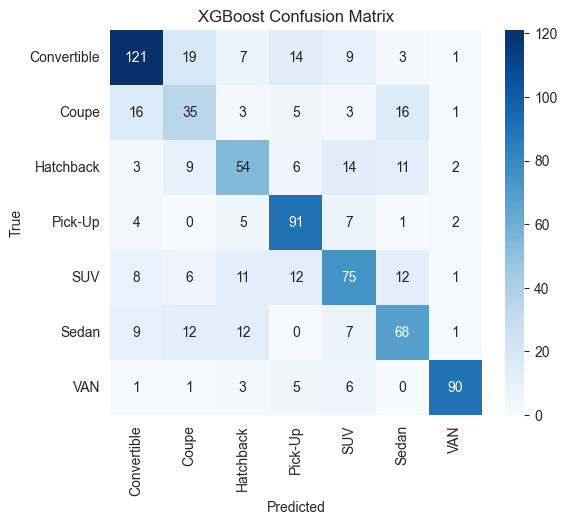

In [13]:
xgb_model = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42
)

# Train
xgb_model.fit(X_train_pca, y_train_enc)

# Validation
y_val_pred = xgb_model.predict(X_val_pca)
xgb_val_acc = accuracy_score(y_val_enc, y_val_pred)
print("XGBoost Validation Accuracy:", xgb_val_acc)

# Testing
y_test_pred = xgb_model.predict(X_test_pca)
xgb_test_acc = accuracy_score(y_test_enc, y_test_pred)
print("XGBoost Test Accuracy:", xgb_test_acc)

print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

# ---- Confusion Matrix ----
cm = confusion_matrix(y_test_enc, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("XGBoost Confusion Matrix")
plt.show()


### ANN (MLP) Model

ANN Validation Accuracy: 0.7559055118110236
ANN Test Accuracy: 0.7244389027431422
              precision    recall  f1-score   support

 Convertible       0.79      0.78      0.79       174
       Coupe       0.48      0.61      0.54        79
   Hatchback       0.60      0.59      0.59        99
     Pick-Up       0.76      0.85      0.80       110
         SUV       0.74      0.64      0.69       125
       Sedan       0.74      0.59      0.65       109
         VAN       0.88      0.96      0.92       106

    accuracy                           0.72       802
   macro avg       0.71      0.72      0.71       802
weighted avg       0.73      0.72      0.72       802



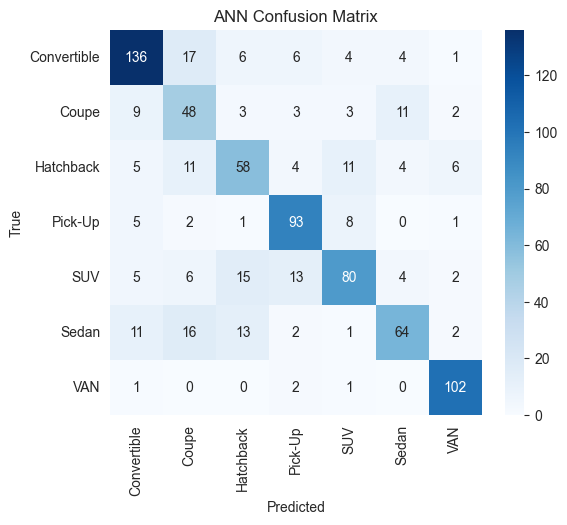

In [14]:
ann_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

# Train
ann_model.fit(X_train_pca, y_train_enc)

# Validation
y_val_pred = ann_model.predict(X_val_pca)
ann_val_acc = accuracy_score(y_val_enc, y_val_pred)
print("ANN Validation Accuracy:", ann_val_acc)

# Testing
y_test_pred = ann_model.predict(X_test_pca)
ann_test_acc = accuracy_score(y_test_enc, y_test_pred)
print("ANN Test Accuracy:", ann_test_acc)

print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

# ---- Confusion Matrix ----
cm = confusion_matrix(y_test_enc, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ANN Confusion Matrix")
plt.show()


## SVM Tuning

Best SVM Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Accuracy: 0.7908413164691946
Tuned SVM Test Accuracy: 0.8192019950124688
              precision    recall  f1-score   support

 Convertible       0.86      0.89      0.87       174
       Coupe       0.64      0.71      0.67        79
   Hatchback       0.71      0.69      0.70        99
     Pick-Up       0.87      0.88      0.87       110
         SUV       0.85      0.78      0.81       125
       Sedan       0.76      0.78      0.77       109
         VAN       0.99      0.94      0.97       106

    accuracy                           0.82       802
   macro avg       0.81      0.81      0.81       802
weighted avg       0.82      0.82      0.82       802



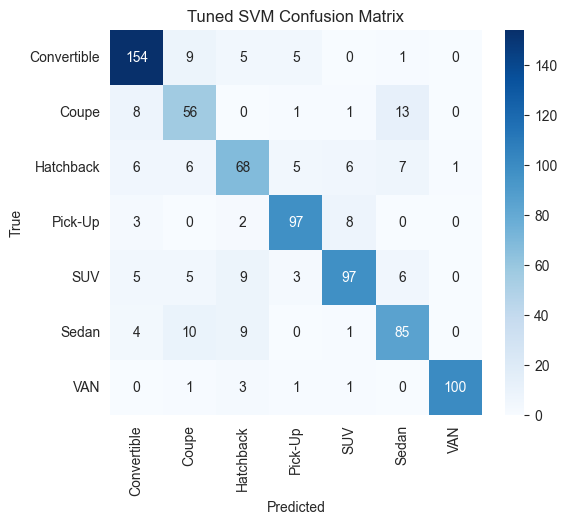

In [15]:
## Tuned SVM using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 50],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(
    SVC(),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train_pca, y_train_enc)

svm_tuned = grid.best_estimator_

print("Best SVM Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

y_test_pred = svm_tuned.predict(X_test_pca)
svm_tuned_test_acc = accuracy_score(y_test_enc, y_test_pred)

print("Tuned SVM Test Accuracy:", svm_tuned_test_acc)
print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_enc, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Tuned SVM Confusion Matrix")
plt.show()

## Comparison

In [16]:
## Model Comparison (Test Accuracy)
models_dict = {
    "SVM": svm_model,
    "SVM (Tuned)": svm_tuned,
    "Random Forest": rf_model,
    "KNN": knn_model,
    "XGBoost": xgb_model,
    "ANN": ann_model
}

results = {
    "SVM": svm_test_acc,
    "SVM (Tuned)": svm_tuned_test_acc,
    "Random Forest": rf_test_acc,
    "KNN": knn_test_acc,
    "XGBoost": xgb_test_acc,
    "ANN": ann_test_acc
}

for model, acc in results.items():
    print(f"{model}: {acc:.4f}")

SVM: 0.8017
SVM (Tuned): 0.8192
Random Forest: 0.5374
KNN: 0.6172
XGBoost: 0.6658
ANN: 0.7244


## SVM + CNN For Comparison

Feature dimensions after PCA: (5350, 442)
Validation Accuracy (CNN + SVM): 0.8332140300644237
Test Accuracy (CNN + SVM): 0.827930174563591

Classification Report (Test Set):
              precision    recall  f1-score   support

 Convertible       0.84      0.91      0.88       174
       Coupe       0.69      0.70      0.69        79
   Hatchback       0.76      0.71      0.73        99
     Pick-Up       0.87      0.88      0.88       110
         SUV       0.85      0.78      0.82       125
       Sedan       0.75      0.81      0.78       109
         VAN       0.99      0.92      0.95       106

    accuracy                           0.83       802
   macro avg       0.82      0.82      0.82       802
weighted avg       0.83      0.83      0.83       802



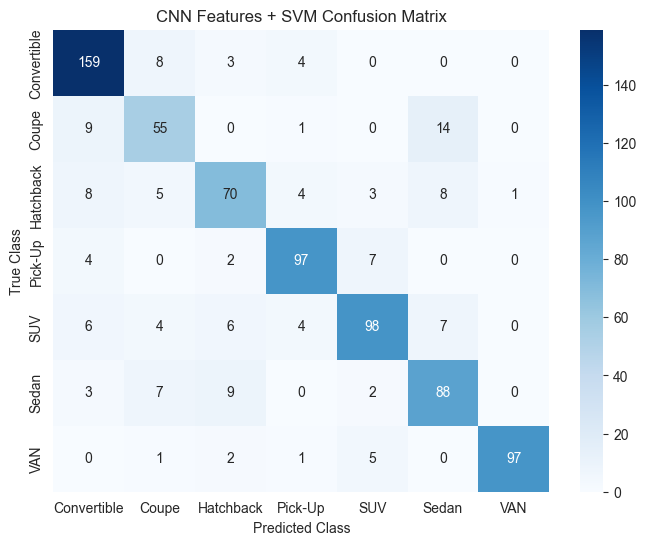

In [17]:
# --- Reduce dimensionality more aggressively for SVM ---
pca = PCA(n_components=0.95, random_state=42)  # keep 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Feature dimensions after PCA:", X_train_pca.shape)

# --- Train SVM with tuned hyperparameters ---
svm_model = SVC(C=10, gamma=0.001, kernel='rbf', class_weight='balanced', random_state=42)
svm_model.fit(X_train_pca, y_train_enc)

# --- Validate ---
y_val_pred = svm_model.predict(X_val_pca)
val_acc = accuracy_score(y_val_enc, y_val_pred)
print("Validation Accuracy (CNN + SVM):", val_acc)

# --- Test ---
y_test_pred = svm_model.predict(X_test_pca)
test_acc = accuracy_score(y_test_enc, y_test_pred)
print("Test Accuracy (CNN + SVM):", test_acc)

print("\nClassification Report (Test Set):")
print(classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_enc, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("CNN Features + SVM Confusion Matrix")
plt.show()